In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
np.random.seed(0)
data_path = '/content/diabetic_data.csv'

df = pd.read_csv(data_path, na_filter=True, na_values=['?', np.nan])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data set has 49 features and 101766 lines.

Shuffle and split the dataset into:  
a). 70% of the entire Dataset for training (Training data)  
b). 15% of the entire Dataset for validation (Validation data)  
c). 15% of the entire Dataset for testing (Testing data)

In [ ]:
# Based on ID_mapping.csv, 11, 19, 20, 21 are related to that patient expire. So we should remove these data.
df = df.loc[~df.discharge_disposition_id.isin([11,19,20,21])]

df = df.loc[~df.gender.isin(['Unknown/Invalid'])]

df = df.loc[~df.acetohexamide.isin(['Steady'])] #Only 1 Steady entry, exlude from dataset.
df = df.loc[~df.troglitazone.isin(['Steady'])]
# df = df.loc[~df.glimepiride-pioglitazone.isin(['Steady'])]#Only 1 Steady entry, exlude from dataset.
df = df.drop(['payer_code'], axis=1)

# diag_1, 2, 3 has unknown data like V58, V27

#df = df.drop(['diag_1'], axis=1)
#df = df.drop(['diag_2'], axis=1)
#df = df.drop(['diag_3'], axis=1)

# All "no"
df = df.drop(['acetohexamide'], axis=1)
df = df.drop(['troglitazone'], axis=1)
df = df.drop(['glimepiride-pioglitazone'], axis=1)

# Too many Null entry
# df = df.drop(['weight'], axis=1)

df = df.drop(['encounter_id'], axis=1)
df = df.drop(['patient_nbr'], axis=1)

#Drop diag_x = 783
indexNames = df[df['diag_1'] == "783" ].index
df.drop(indexNames , inplace=True)
indexNames = df[df['diag_2'] == "783" ].index
df.drop(indexNames , inplace=True)
indexNames = df[df['diag_3'] == "783" ].index
df.drop(indexNames , inplace=True)


indexNames = df[df['diag_1'] == "789" ].index
df.drop(indexNames , inplace=True)
indexNames = df[df['diag_2'] == "789" ].index
df.drop(indexNames , inplace=True)
indexNames = df[df['diag_3'] == "789" ].index
df.drop(indexNames , inplace=True)


The number of unique variable in medical_speciality is so large. So we will group thses variables into 11 groups(top 10 specialities + other)

In [ ]:
top10 = ['InternalMedicine','Family/GeneralPractice','Cardiology','Surgery-General',\
         'Orthopedics-Reconstructive','Orthopedics','Nephrology','Psychiatry','Pulmonology','Emergency/Trauma']

df.loc[~df.medical_specialty.isin(top10),'medical_specialty'] = 'Other'

In [ ]:
df_train, df_validate, df_test = np.split(df.sample(frac=1), [int(.7*len(df)), int(.85*len(df))])

# readmitted: NO = 0, <30 = 1, >30 = 0
readmitted = {'NO':0,'<30':1,'>30':0}
y_train = df_train["readmitted"].replace(readmitted)
y_validate = df_validate["readmitted"].replace(readmitted)
y_test = df_test["readmitted"].replace(readmitted)

df_train = df_train.drop(['readmitted'], axis=1)
df_validate = df_validate.drop(['readmitted'], axis=1)
df_test = df_test.drop(['readmitted'], axis=1)

# gender: Female=0,Male=1
gender = {'Female':0,'Male':1}
df_train['gender'] = df_train["gender"].replace(gender)
df_validate['gender'] = df_validate["gender"].replace(gender)
df_test['gender'] = df_test["gender"].replace(gender)

age = {'[0-10)':0,'[10-20)':1,'[20-30)':2, '[30-40)': 3, '[40-50)':4, '[50-60)':5, '[60-70)':6, '[70-80)':7, '[80-90)':8, '[90-100)':9}
df_train['age'] = df_train["age"].replace(age)
df_validate['age'] = df_validate["age"].replace(age)
df_test['age'] = df_test["age"].replace(age)

race = {'AfricanAmerican':0, 'Asian':1, 'Caucasian':2, 'Hispanic':3, 'Other':4}
df_train['race'] = df_train["race"].replace(race)
df_validate['race'] = df_validate["race"].replace(race)
df_test['race'] = df_test["race"].replace(race)

weight = {'[0-25)':0,'[25-50)':1, '[50-75)':2, '[75-100)':3, '[100-125)':4, '[125-150)':5, '[150-175)':6, '[175-200)':7, '>200':8}
df_train['weight'] = df_train["weight"].replace(weight)
df_validate['weight'] = df_validate["weight"].replace(weight)
df_test['weight'] = df_test["weight"].replace(weight)

max_glu_serum = {'None':0, 'Norm':1, '>200': 2, '>300': 3}
df_train['max_glu_serum'] = df_train["max_glu_serum"].replace(max_glu_serum)
df_validate['max_glu_serum'] = df_validate["max_glu_serum"].replace(max_glu_serum)
df_test['max_glu_serum'] = df_test["max_glu_serum"].replace(max_glu_serum)

A1Cresult = {'None':0, 'Norm':1, '>7': 2, '>8': 3}
df_train['A1Cresult'] = df_train["A1Cresult"].replace(A1Cresult)
df_validate['A1Cresult'] = df_validate["A1Cresult"].replace(A1Cresult)
df_test['A1Cresult'] = df_test["A1Cresult"].replace(A1Cresult)

DownNoSteadyUp = {'Down': 0, 'No':1, 'Steady':2, 'Up':3}
for each in ['metformin', 'repaglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 
             'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
             'metformin-rosiglitazone', 'metformin-pioglitazone', "nateglinide"]:
  df_train[each] = df_train[each].replace(DownNoSteadyUp)
  df_validate[each] = df_validate[each].replace(DownNoSteadyUp)
  df_test[each] = df_test[each].replace(DownNoSteadyUp)


change = {"Ch":0, "No":1}
df_train["change"] = df_train["change"].replace(change)
df_validate["change"] = df_validate["change"].replace(change)
df_test["change"] = df_test["change"].replace(change)



diabetesMed = {"Yes":0, "No":1}
df_train["diabetesMed"] = df_train["diabetesMed"].replace(diabetesMed)
df_validate["diabetesMed"] = df_validate["diabetesMed"].replace(diabetesMed)
df_test["diabetesMed"] = df_test["diabetesMed"].replace(diabetesMed)

# Warning: only 21 entries is Steady
tolbutamide = {"No":0, "Steady":1}
df_train["tolbutamide"] = df_train["tolbutamide"].replace(tolbutamide)
df_validate["tolbutamide"] = df_validate["tolbutamide"].replace(tolbutamide)
df_test["tolbutamide"] = df_test["tolbutamide"].replace(tolbutamide)


Converting diag_1, diag_2, diag_3 according to https://www.hindawi.com/journals/bmri/2014/781670/tab2/

In [ ]:
# Converting diag_1, 2, 3



# See table: https://www.hindawi.com/journals/bmri/2014/781670/tab2/
diag_replace_dict = dict()

#Circulatory = 0
for each in range(390, 460):
  diag_replace_dict[str(each)] = 0
diag_replace_dict[str(785)] = 0

#Respiratory = 1
for each in range(460, 520):
  diag_replace_dict[str(each)] = 1
diag_replace_dict[str(786)] = 1

#Digestive = 2
for each in range(520, 580):
  diag_replace_dict[str(each)] = 2
diag_replace_dict[str(787)] = 2

#Diabetes = 3
# code = 250.xx
df_train['diag_1'] = df_train["diag_1"].replace(to_replace=r'^[2][5][0].[0-9]*$', value=3, regex=True)
df_validate['diag_1'] = df_validate["diag_1"].replace(to_replace=r'^[2][5][0].[0-9]*$', value=3, regex=True)
df_test['diag_1'] = df_test["diag_1"].replace(to_replace=r'^[2][5][0].[0-9]*$', value=3, regex=True)

df_train['diag_2'] = df_train["diag_2"].replace(to_replace=r'^[2][5][0].[0-9]*$', value=3, regex=True)
df_validate['diag_2'] = df_validate["diag_2"].replace(to_replace=r'^[2][5][0].[0-9]*$', value=3, regex=True)
df_test['diag_2'] = df_test["diag_2"].replace(to_replace=r'^[2][5][0].[0-9]*$', value=3, regex=True)

df_train['diag_3'] = df_train["diag_3"].replace(to_replace=r'^[2][5][0].[0-9]*$', value=3, regex=True)
df_validate['diag_3'] = df_validate["diag_3"].replace(to_replace=r'^[2][5][0].[0-9]*$', value=3, regex=True)
df_test['diag_3'] = df_test["diag_3"].replace(to_replace=r'^[2][5][0].[0-9]*$', value=3, regex=True)
diag_replace_dict[str(250)] = 3
#Injury = 4
for each in range(800, 1000):
  diag_replace_dict[str(each)] = 4

#Musculoosk eletal = 5
for each in range(710, 740):
  diag_replace_dict[str(each)] = 5

#Genitourinary = 6
for each in range(580, 630):
  diag_replace_dict[str(each)] = 6
diag_replace_dict[str(788)] = 6

#Neoplasms = 7
for each in range(140, 240):
  diag_replace_dict[str(each)] = 7
diag_replace_dict[str(780)] = 7
diag_replace_dict[str(781)] = 7
diag_replace_dict[str(784)] = 7
for each in range(790, 800):
  diag_replace_dict[str(each)] = 7
for each in range(240, 250):
  diag_replace_dict[str(each)] = 7
for each in range(251, 280):
  diag_replace_dict[str(each)] = 7
for each in range(680, 710):
  diag_replace_dict[str(each)] = 7
diag_replace_dict[str(782)] = 7
for each in range(1, 140):
  diag_replace_dict[str(each)] = 7

#Other = 8
for each in range(290, 320):
  diag_replace_dict[str(each)] = 8
df_train['diag_1'] = df_train["diag_1"].replace(to_replace=r'^E[0-9]*$', value=8, regex=True)
df_validate['diag_1'] = df_validate["diag_1"].replace(to_replace=r'^E[0-9]*$', value=8, regex=True)
df_test['diag_1'] = df_test["diag_1"].replace(to_replace=r'^E[0-9]*$', value=8, regex=True)

df_train['diag_2'] = df_train["diag_2"].replace(to_replace=r'^E[0-9]*$', value=8, regex=True)
df_validate['diag_2'] = df_validate["diag_2"].replace(to_replace=r'^E[0-9]*$', value=8, regex=True)
df_test['diag_2'] = df_test["diag_2"].replace(to_replace=r'^E[0-9]*$', value=8, regex=True)

df_train['diag_3'] = df_train["diag_3"].replace(to_replace=r'^E[0-9]*$', value=8, regex=True)
df_validate['diag_3'] = df_validate["diag_3"].replace(to_replace=r'^E[0-9]*$', value=8, regex=True)
df_test['diag_3'] = df_test["diag_3"].replace(to_replace=r'^E[0-9]*$', value=8, regex=True)

df_train['diag_1'] = df_train["diag_1"].replace(to_replace=r'^V[0-9]*$', value=8, regex=True)
df_validate['diag_1'] = df_validate["diag_1"].replace(to_replace=r'^V[0-9]*$', value=8, regex=True)
df_test['diag_1'] = df_test["diag_1"].replace(to_replace=r'^V[0-9]*$', value=8, regex=True)

df_train['diag_2'] = df_train["diag_2"].replace(to_replace=r'^V[0-9]*$', value=8, regex=True)
df_validate['diag_2'] = df_validate["diag_2"].replace(to_replace=r'^V[0-9]*$', value=8, regex=True)
df_test['diag_2'] = df_test["diag_2"].replace(to_replace=r'^V[0-9]*$', value=8, regex=True)

df_train['diag_3'] = df_train["diag_3"].replace(to_replace=r'^V[0-9]*$', value=8, regex=True)
df_validate['diag_3'] = df_validate["diag_3"].replace(to_replace=r'^V[0-9]*$', value=8, regex=True)
df_test['diag_3'] = df_test["diag_3"].replace(to_replace=r'^V[0-9]*$', value=8, regex=True)

for each in range(280, 290):
  diag_replace_dict[str(each)] = 8
for each in range(320, 360):
  diag_replace_dict[str(each)] = 8
for each in range(630, 680):
  diag_replace_dict[str(each)] = 8
for each in range(360, 390):
  diag_replace_dict[str(each)] = 8
for each in range(740, 760):
  diag_replace_dict[str(each)] = 8

df_train['diag_1'] = df_train["diag_1"].replace(diag_replace_dict)
df_validate['diag_1'] = df_validate["diag_1"].replace(diag_replace_dict)
df_test['diag_1'] = df_test["diag_1"].replace(diag_replace_dict)

df_train['diag_2'] = df_train["diag_2"].replace(diag_replace_dict)
df_validate['diag_2'] = df_validate["diag_2"].replace(diag_replace_dict)
df_test['diag_2'] = df_test["diag_2"].replace(diag_replace_dict)

df_train['diag_3'] = df_train["diag_3"].replace(diag_replace_dict)
df_validate['diag_3'] = df_validate["diag_3"].replace(diag_replace_dict)
df_test['diag_3'] = df_test["diag_3"].replace(diag_replace_dict)

df_train["diag_1"].fillna(9, inplace = True)
df_validate["diag_1"].fillna(9, inplace = True) 
df_test["diag_1"].fillna(9, inplace = True)

df_train["diag_2"].fillna(9, inplace = True)
df_validate["diag_2"].fillna(9, inplace = True) 
df_test["diag_2"].fillna(9, inplace = True)

df_train["diag_3"].fillna(9, inplace = True)
df_validate["diag_3"].fillna(9, inplace = True) 
df_test["diag_3"].fillna(9, inplace = True)

In [ ]:
df_validate.groupby('diag_3').size().sort_values(ascending = False)

diag_3
0    4264
7    2691
3    2531
8    1941
1    1074
6     959
2     536
4     315
5     314
9     201
dtype: int64

In [ ]:
df.groupby('medical_specialty').size().sort_values(ascending = False)

medical_specialty
Other                         56089
InternalMedicine              14112
Emergency/Trauma               7322
Family/GeneralPractice         7186
Cardiology                     5277
Surgery-General                3011
Nephrology                     1527
Orthopedics                    1394
Orthopedics-Reconstructive     1231
Psychiatry                      849
Pulmonology                     839
dtype: int64

In [ ]:
df.groupby('medical_specialty').size().sort_values(ascending = False)

medical_specialty
Other                         56089
InternalMedicine              14112
Emergency/Trauma               7322
Family/GeneralPractice         7186
Cardiology                     5277
Surgery-General                3011
Nephrology                     1527
Orthopedics                    1394
Orthopedics-Reconstructive     1231
Psychiatry                      849
Pulmonology                     839
dtype: int64

In [ ]:
med_spec = {'Other':0,'InternalMedicine':1,'Emergency/Trauma':2,'Family/GeneralPractice':3,
            'Cardiology':4,'Surgery-General':5,'Nephrology':6,'Orthopedics':7,'Orthopedics-Reconstructive':8,
            'Pulmonology':9, 'Psychiatry':10}
df_train['medical_specialty'] = df_train["medical_specialty"].replace(med_spec)
df_validate['medical_specialty'] = df_validate["medical_specialty"].replace(med_spec)
df_test['medical_specialty'] = df_test["medical_specialty"].replace(med_spec)

In [ ]:
assert df_train.shape[0]+df_validate.shape[0]+df_test.shape[0] == df.shape[0]

In [ ]:
'''medical_specialty_keys = df.groupby('medical_specialty').groups.keys()
medical_specialty_index = list(enumerate(list(medical_specialty_keys),1))

medical_specialty = dict()
for each in medical_specialty_index:
  medical_specialty[each[1]] = each[0]


df_train["medical_specialty"] = df_train["medical_specialty"].replace(medical_specialty)
df_validate["medical_specialty"] = df_validate["medical_specialty"].replace(medical_specialty)
df_test["medical_specialty"] = df_test["medical_specialty"].replace(medical_specialty)'''


df_train["medical_specialty"].fillna(11, inplace = True)
df_validate["medical_specialty"].fillna(11, inplace = True) 
df_test["medical_specialty"].fillna(11, inplace = True)

df_train["race"].fillna(5, inplace = True) 
df_validate["race"].fillna(5, inplace = True) 
df_test["race"].fillna(5, inplace = True) 

df_train["weight"].fillna(9, inplace = True) 
df_validate["weight"].fillna(9, inplace = True) 
df_test["weight"].fillna(9, inplace = True)

In [ ]:
df_train.to_csv('df_train.csv',index=False)
df_validate.to_csv('df_validate.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [ ]:
df_train.isnull().sum()

race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
tolazamide

In [ ]:
df.groupby('medical_specialty').size().sort_values(ascending = False)

medical_specialty
Other                         56089
InternalMedicine              14112
Emergency/Trauma               7322
Family/GeneralPractice         7186
Cardiology                     5277
Surgery-General                3011
Nephrology                     1527
Orthopedics                    1394
Orthopedics-Reconstructive     1231
Psychiatry                      849
Pulmonology                     839
dtype: int64

In [ ]:
df["number_diagnoses"].describe()

count    98837.000000
mean         7.407641
std          1.939043
min          1.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         16.000000
Name: number_diagnoses, dtype: float64

In [ ]:
# for each column
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

race
['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
[nan '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 14 18  8 13 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
medical_specialty
['Other' 'InternalMedicine' 'Family/GeneralPractice' 'Cardiology'
 'Surgery-General' 'Orthopedics' 'Nephrology' 'Orthopedics-Reconstructive'
 'Psychiatry' 'Emergency/Trauma' 'Pulmonology']
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6  5  4  7  9

In [ ]:
y_train_color = []
for each in y_train:
  if each == 0:
    y_train_color.append("red")
  else:
    y_train_color.append("green")

Text(0, 0.5, 'weight')

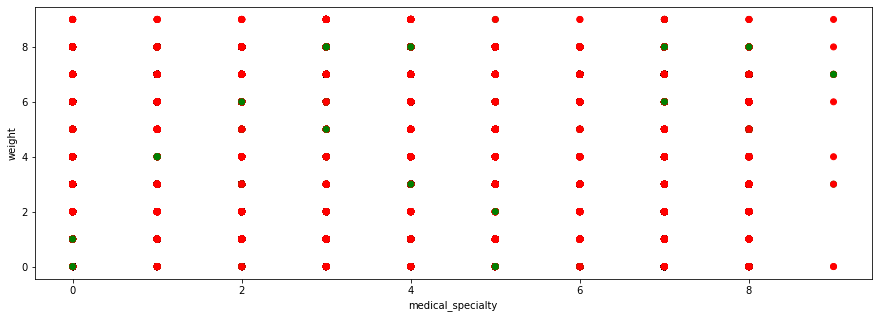

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(df_train['diag_1'], df_train['diag_2'], c=y_train_color)
plt.xlabel('medical_specialty')
plt.ylabel('weight')

#Training Model

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [ ]:
# TODO: Balance dataset.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(df_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

KNN


In [ ]:
n_neighbors_list = [5, 25, 50, 100, 250, 500]
knn_auc_train_result = []
knn_auc_validate_result = []

for n_neighbors in n_neighbors_list:
  print("n_neighbors:", n_neighbors)
  knn=KNeighborsClassifier(n_neighbors = n_neighbors)
  knn.fit(df_train, y_train)
  thresh = 0.5

  y_train_preds = knn.predict_proba(df_train)[:,1]
  y_valid_preds = knn.predict_proba(df_validate)[:,1]

  knn_train_auc, knn_train_accuracy, knn_train_recall, knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
  knn_auc_train_result.append(knn_train_auc)
  knn_train_auc, knn_train_accuracy, knn_train_recall, knn_train_precision, knn_train_specificity = print_report(y_validate,y_valid_preds, thresh)
  knn_auc_validate_result.append(knn_train_auc)

n_neighbors: 5
AUC:0.872
accuracy:0.892
recall:0.095
precision:0.644
specificity:0.993
prevalence:0.113
 
AUC:0.550
accuracy:0.877
recall:0.034
precision:0.227
specificity:0.985
prevalence:0.114
 
n_neighbors: 25
AUC:0.723
accuracy:0.888
recall:0.003
precision:0.765
specificity:1.000
prevalence:0.113
 
AUC:0.569
accuracy:0.886
recall:0.002
precision:0.364
specificity:0.999
prevalence:0.114
 
n_neighbors: 50
AUC:0.681
accuracy:0.887
recall:0.000
precision:0.500
specificity:1.000
prevalence:0.113
 
AUC:0.588
accuracy:0.886
recall:0.001
precision:1.000
specificity:1.000
prevalence:0.114
 
n_neighbors: 100


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC:0.655
accuracy:0.887
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.113
 
AUC:0.596
accuracy:0.886
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.114
 
n_neighbors: 250


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC:0.631
accuracy:0.887
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.113
 
AUC:0.596
accuracy:0.886
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.114
 
n_neighbors: 500
AUC:0.617
accuracy:0.887
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.113
 
AUC:0.602
accuracy:0.886
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.114
 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
knn_auc_train_result

[0.8715388481471062,
 0.723441085245353,
 0.681362173894803,
 0.6545333546859103,
 0.6309464614669126,
 0.616765822037214]

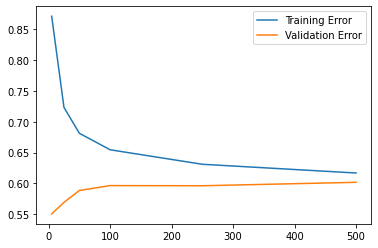

In [ ]:
plt.plot(n_neighbors_list, knn_auc_train_result, n_neighbors_list, knn_auc_validate_result) 
plt.legend(['Training Error', 'Validation Error'])
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(df_train, y_train)

y_train_preds = lr.predict_proba(df_train)[:,1]
y_valid_preds = lr.predict_proba(df_validate)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_validate,y_valid_preds, thresh)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression
Training:
AUC:0.644
accuracy:0.887
recall:0.015
precision:0.477
specificity:0.998
prevalence:0.113
 
Validation:
AUC:0.635
accuracy:0.886
recall:0.014
precision:0.480
specificity:0.998
prevalence:0.114
 


In [ ]:
# New logistic with diag_123
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(df_train, y_train)

y_train_preds = lr.predict_proba(df_train)[:,1]
y_valid_preds = lr.predict_proba(df_validate)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_validate,y_valid_preds, thresh)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression
Training:
AUC:0.644
accuracy:0.887
recall:0.015
precision:0.477
specificity:0.998
prevalence:0.113
 
Validation:
AUC:0.635
accuracy:0.886
recall:0.014
precision:0.480
specificity:0.998
prevalence:0.114
 


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(df_train, y_train)

y_train_preds = tree.predict_proba(df_train)[:,1]
y_valid_preds = tree.predict_proba(df_validate)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_validate,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.707
accuracy:0.895
recall:0.090
precision:0.802
specificity:0.997
prevalence:0.113
 
Validation:
AUC:0.622
accuracy:0.882
recall:0.041
precision:0.337
specificity:0.989
prevalence:0.114
 


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 8, random_state = 42)
rf.fit(df_train, y_train)

y_train_preds = rf.predict_proba(df_train)[:,1]
y_valid_preds = rf.predict_proba(df_validate)[:,1]
y_test_preds = rf.predict_proba(df_test)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_validate,y_valid_preds, thresh)
print('Test')
rf_test_auc, rf_test_accuracy, rf_test_recall, rf_test_precision, rf_test_specificity = print_report(y_test, y_test_preds, thresh)

Random Forest
Training:
AUC:0.708
accuracy:0.887
recall:0.144
precision:0.491
specificity:0.981
prevalence:0.113
 
Validation:
AUC:0.657
accuracy:0.876
recall:0.090
precision:0.330
specificity:0.976
prevalence:0.114
 
Test
AUC:0.669
accuracy:0.874
recall:0.099
precision:0.345
specificity:0.975
prevalence:0.116
 


In [ ]:
thresh = 0.2
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 8, random_state = 42)
rf.fit(df_train, y_train)

y_train_preds = rf.predict_proba(df_train)[:,1]
y_valid_preds = rf.predict_proba(df_validate)[:,1]
y_test_preds = rf.predict_proba(df_test)[:,1]

print('Random Forest with diag_123')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_validate,y_valid_preds, thresh)
print('Test')
rf_test_auc, rf_test_accuracy, rf_test_recall, rf_test_precision, rf_test_specificity = print_report(y_test, y_test_preds, thresh)

Random Forest with diag_123
Training:
AUC:0.708
accuracy:0.887
recall:0.144
precision:0.491
specificity:0.981
prevalence:0.113
 
Validation:
AUC:0.657
accuracy:0.876
recall:0.090
precision:0.330
specificity:0.976
prevalence:0.114
 
Test
AUC:0.669
accuracy:0.874
recall:0.099
precision:0.345
specificity:0.975
prevalence:0.116
 


Optimize Random Forest

Hyperparameter tuning: the desgin decisions that made when set up the machine learning model. Eg, the maximum depth for random forest.
Here we will use a technique called Grid search where we can test all possible combinations of parameters

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Now we will create a grid over a few of these

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,15,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 15), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


Score/evaluate hyperparameters

In [ ]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

scoring = evaluation metric used to pick the best model

n_iter = number of different combinations

cv = number of cros-validaiton splits

Increasing the last two of these will increase the run-time, but will decrease chance of overfitting.  Note that the number of variables and grid size also influences the runtime. Cross-validation is a technique for splitting the data multiple times to get a better estimate of the performance metric. For the purposes of this tutorial, we will restrict to 2 CV to reduce the time.

In [ ]:
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(df_train, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  7.0min finished


429.6468708515167


In [ ]:
rf_random.best_params_    # see the best parameters

{'criterion': 'gini',
 'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_split': 6,
 'n_estimators': 200}

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf_opt=RandomForestClassifier(criterion='gini',max_depth = 14, random_state = 42,
                          max_features = 'sqrt',min_samples_split=6,
                          n_estimators=200)
rf_opt.fit(df_train, y_train)


y_train_preds_opt = rf_opt.predict_proba(df_train)[:,1]
y_valid_preds_opt = rf_opt.predict_proba(df_validate)[:,1]

print('Optimized Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds_opt, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_validate,y_valid_preds_opt, thresh)

Optimized Random Forest
Training:
AUC:0.886
accuracy:0.921
recall:0.439
precision:0.763
specificity:0.983
prevalence:0.113
 
Validation:
AUC:0.658
accuracy:0.863
recall:0.154
precision:0.302
specificity:0.954
prevalence:0.114
 


The validation AUC before optimization is 0.662.
It seems that optimizing RF model doesn't improve performance a lot...

Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='adam',alpha=1e-5,random_state=1,activation='tanh')

nn.fit(df_train, y_train)

y_train_preds = nn.predict_proba(df_train)[:,1]
y_valid_preds = nn.predict_proba(df_validate)[:,1]

print('Neural Network')
print('Training:')
nn_train_auc, nn_train_accuracy, nn_train_recall, nn_train_precision, nn_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nn_valid_auc, nn_valid_accuracy, nn_valid_recall, nn_valid_precision, nn_valid_specificity = print_report(y_validate,y_valid_preds, thresh)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Network
Training:
AUC:0.771
accuracy:0.894
recall:0.089
precision:0.733
specificity:0.996
prevalence:0.113
 
Validation:
AUC:0.613
accuracy:0.880
recall:0.034
precision:0.278
specificity:0.989
prevalence:0.114
 


Optimize Neural Network

In [ ]:
nn.get_params()

{'activation': 'tanh',
 'alpha': 1e-05,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [ ]:
activation = ['identity','logistic','tanh','relu']
hidden_layer_sizes = []
for i in range(50,210,10):
  hidden_layer_sizes.append((i,))
solver = ['lbfgs','sgd','adam']
learning_rate = ['constant','invscaling','adaptive']


nn_grid = {'activation':activation, 'hidden_layer_sizes':hidden_layer_sizes,
           'solver':solver, 'learning_rate':learning_rate}

print(nn_grid)

{'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(50,), (60,), (70,), (80,), (90,), (100,), (110,), (120,), (130,), (140,), (150,), (160,), (170,), (180,), (190,), (200,)], 'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}


In [ ]:
nn_random = RandomizedSearchCV(estimator = nn, param_distributions = nn_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

t1 = time.time()
nn_random.fit(df_train, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: Convergenc

1683.8589251041412


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
nn_random.best_params_ 

{'activation': 'tanh',
 'hidden_layer_sizes': (150,),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [ ]:
nn_opt = MLPClassifier(solver='adam',learning_rate='constant',
                             hidden_layer_sizes=(80,),activation='identity')
nn_opt.fit(df_train, y_train)


y_train_preds_opt = nn_opt.predict_proba(df_train)[:,1]
y_valid_preds_opt = nn_opt.predict_proba(df_validate)[:,1]

print('Optimized Random Forest')
print('Training:')
nn_train_auc, nn_train_accuracy, nn_train_recall, nn_train_precision, nn_train_specificity = print_report(y_train,y_train_preds_opt, thresh)
print('Validation:')
nn_valid_auc, nn_valid_accuracy, nn_valid_recall, nn_valid_precision, nn_valid_specificity = print_report(y_validate,y_valid_preds_opt, thresh)

Optimized Random Forest
Training:
AUC:0.643
accuracy:0.887
recall:0.016
precision:0.473
specificity:0.998
prevalence:0.113
 
Validation:
AUC:0.632
accuracy:0.886
recall:0.014
precision:0.471
specificity:0.998
prevalence:0.114
 
